# 权重衰退

## 权重衰退 weight decay 是最广泛使用的正则化的技术之一

In [1]:
%matplotlib inline
# 导入工具包
import torch
from torch import nn
from d2l import torch as d2l

### 像以前一样生成一些数据

- 生成公式： $𝑦=0.05+\sum\limits_{𝑖=1}^𝑑0.01𝑥_𝑖 + 𝜖$ ，  $where 𝜖∼\mathcal{N}(0,0.012)$

- 我们选择标签是关于输入的线性函数
- 标签同时被均值为0，标准差为0.01高斯噪声破坏

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5  # 20个样本的小训练集 越小越容易过拟合， test选大一点, 问题的维数增加到 𝑑=200 
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05  # 真是的 w b
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

- 下面我们将从头开始实现权重衰减，只需将 𝐿2 的平方惩罚添加到原始目标函数中。

### 初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True) # 需要梯度因为需要计算
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义 𝐿2 范数惩罚

- 实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) /2  # 不要开方，因为是 L2 范数的平方

### 定义训练代码实现


In [5]:
def train(lambd):   # 接受 lambda 超参数
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss  # 线性回归 平方损失函数
    num_epochs, lr = 100, 0.003   # 迭代100次，训练长一点，因为样本比较少
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练

- 注意，这里训练误差有了减少，但测试误差没有减少， 这意味着出现了严重的过拟合。

w的L2范数是： 14.109155654907227


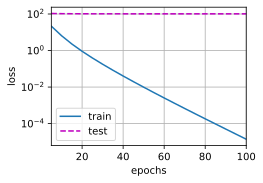

In [6]:
train(lambd=0)

### 使用权重衰减

- 注意，在这里训练误差增大，但测试误差减小。 这正是我们期望从正则化中得到的效果。

w的L2范数是： 0.026007702574133873


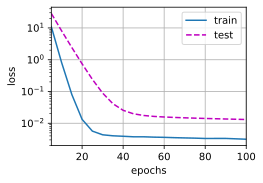

In [8]:
train(lambd=10)

## 简洁实现

- 由于权重衰减在神经网络优化中很常用， 深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。
- 此外，这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。
- 由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},   # 实例化优化器时直接通过weight_decay指定weight decay超参数
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

## 这些图看起来和我们从零开始实现权重衰减时的图相同

w的L2范数： 14.080803871154785


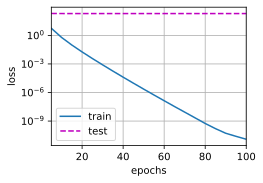

In [10]:
train_concise(0)

w的L2范数： 0.07385002076625824


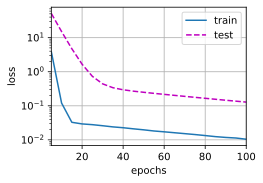

In [16]:
train_concise(10)